# livelossplot example: PyTorch torchbearer

[torchbearer](https://github.com/ecs-vlc/torchbearer) is a model fitting library for PyTorch. As of version 0.2.6 it includes native support for `livelossplot`, through the [LiveLossPlot callback](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.live_loss_plot.LiveLossPlot). In this notebook, we'll train a simple CNN on CIFAR10 with torchbearer and livelossplot.

<a href="https://colab.research.google.com/github/stared/livelossplot/blob/master/examples/torchbearer.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

In [1]:
!pip install torchbearer --quiet

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

import torchbearer
from torchbearer.cv_utils import DatasetValidationSplitter
from torchbearer import Trial
from torchbearer.callbacks import LiveLossPlot

## Data
We'll use CIFAR10 for this demo, with the usual normalisations

In [3]:
BATCH_SIZE = 256

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

dataset = torchvision.datasets.CIFAR10(root='./tmp/cifar', train=True, download=True,
                                        transform=transforms.Compose([transforms.ToTensor(), normalize]))
splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
valgen = torch.utils.data.DataLoader(valset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)


testset = torchvision.datasets.CIFAR10(root='./tmp/cifar', train=False, download=True,
                                       transform=transforms.Compose([transforms.ToTensor(), normalize]))
testgen = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)


Files already downloaded and verified


## Model
A simple, 3 layer CNN should do the trick, since we're using batch norm we won't worry about weight initialisation

In [4]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Linear(576, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 576)
        return self.classifier(x)


model = SimpleModel()

## Running

Now we're ready to run, we use one trial here for the training and validation and one for evaluation

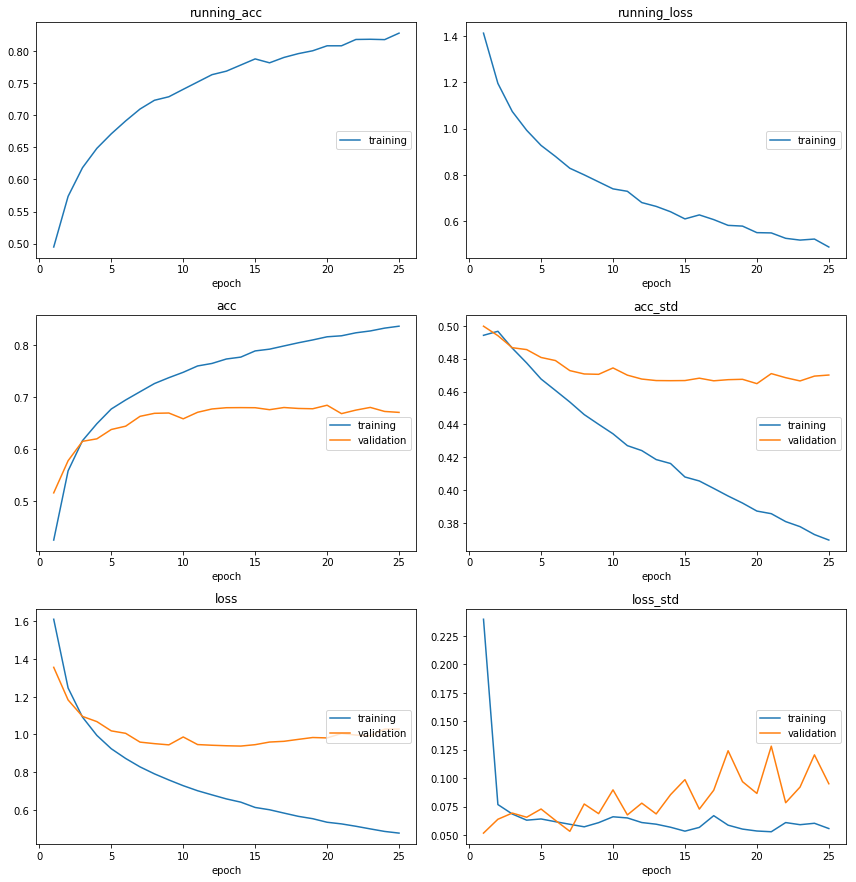

In [5]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

trial = Trial(
    model, optimizer, loss,
    metrics=['acc', 'loss'],
    callbacks=[LiveLossPlot()]).to('cuda')
trial.with_generators(train_generator=traingen, val_generator=valgen)
history = trial.run(verbose=0, epochs=25)

In [6]:
trial = Trial(model, metrics=['acc', 'loss', 'top_5_acc']).with_test_generator(testgen).to('cuda')
_ = trial.evaluate(data_key=torchbearer.TEST_DATA)

0/1(e): 100%|██████████| 40/40 [00:00<00:00, 118.98it/s, test_acc=0.6712, test_acc_std=0.4698, test_loss=0, test_loss_std=0, test_top_5_acc=0.973, test_top_5_acc_std=0.1621]
